In [1]:
import numpy as np
import sklearn as sk
from google.colab import drive
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from joblib import dump, load
import os
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
import copy
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import euclidean_distances
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

In [2]:
'''
!pip install dill
from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")
'''

'\n!pip install dill\nfrom joblib.externals.loky import set_loky_pickler\nset_loky_pickler("dill")\n'

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


Per il locale

In [ ]:
dati = "C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\dati\\testi-3.xlsx"
modelli = "C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\testi\\modelli"

Per colab

In [4]:
dati = "/content/drive/MyDrive/ML/dati/testi-3.xlsx"
modelli = "/content/drive/MyDrive/ML/testi/modelli"

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
wn = nltk.corpus.wordnet

<h1>Caricamento dati ed esplorazione</h1>

locale

In [ ]:
df = pd.read_excel(dati)
df = df.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df = df.rename(columns={"cleaned_website_text":"text", "Category":"label"})
df

colab

In [7]:
df = pd.read_excel(dati)
#df = df.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df = df.rename(columns={"cleaned_website_text":"text", "Category":"label"})
df

,text,label
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel
...,...,...
1371,electroshops home theater decor interiors seat...,Business/Corporate
1372,clean ridge soap company clean ridge soap comp...,Business/Corporate
1373,home page pet crafts exquisitely piece handcut...,Business/Corporate
1374,home theater marketplace home theater seating ...,Business/Corporate


Osserviamo la distribuzione delle classi

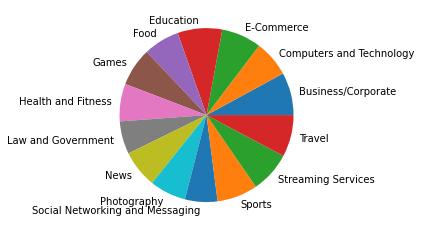

In [8]:
labels = df['label']
labels_singole = np.unique(labels)
conteggio = np.zeros(len(labels_singole))
for i in range(len(labels)):
    label = labels.iloc[i]
    for j in range(len(labels_singole)):
    if labels_singole[j] == label:
        conteggio[j] += 1
plt.pie(conteggio, labels=labels_singole)
plt.show()

Il grafico suggerisce che le classi sono bilanciate, il che ci solleva dal fare data augmentation

In [9]:
X = (df['text'].copy().to_numpy()).astype(str)
y = df['label'].copy().to_numpy()
categorie = (np.unique(y)).tolist()
for i in range(len(y)):
    y[i] = categorie.index(y[i])
y = y.astype(int)

<h1>Preprocessing</h1>

Prepariamo le trasformazioni da inserire nella pipeline

In [10]:
#Ritorna una lista di liste. Ogni lista è un documento fatto a lista di token
class Tokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        import copy
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        import nltk
        import pandas as pd
        wn = nltk.corpus.wordnet
        X_lista = []
        if type(X) != list:
            X_lista = copy.deepcopy(X).tolist()
        else:
            X_lista = copy.deepcopy(X)
        for i in range(len(X_lista)):
            stringa = X_lista[i]
            tokens = word_tokenize(stringa) #tokenizza
            X_lista[i] = tokens
        return X_lista


class NonWordsRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        import copy
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        import nltk
        import pandas as pd
        wn = nltk.corpus.wordnet
        X_ = copy.deepcopy(X)
        for i in range(len(X_)):
            tokens = X_[i]
            da_eliminare = []
            for j in range(len(tokens)):
                sin = wn.synsets(tokens[j])
                #una parola senza sinonimi non è una parola (ogni parola contiene almeno un sinonimo, ossia la parola stessa)
                if sin == []:
                    da_eliminare.append(tokens[j])
            for t in da_eliminare:
                tokens.remove(t)
        return X_


class Lemmatizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        import copy
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        import nltk
        import pandas as pd
        lemmatizer = WordNetLemmatizer()
        wn = nltk.corpus.wordnet
        X_ = copy.deepcopy(X)
        for i in range(len(X_)):
            tokens = X_[i]
            tokens2 = []
            for k in range(len(tokens)):
                tokens2.append(lemmatizer.lemmatize(tokens[k]))
            X_[i] = tokens2
        return X_


#rimuoviamo numeri e parole che contengono numeri
class NumberRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        import copy
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        import nltk
        import pandas as pd
        wn = nltk.corpus.wordnet
        X_ = copy.deepcopy(X)
        numeri = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        #per ogni documento
        for d in X_:
          i = 0
          while i < len(d):
            parola = d[i]
            ok = True
            for j in range(len(parola)):
                if parola[j] in numeri:
                    ok = False
                    break
            if ok:
                i += 1
            else:
                d.pop(i) 
        return X_


class ShortWordRemover(BaseEstimator, TransformerMixin):
    def __init__(self, minimum_length):
        self.minimum_length = minimum_length
  
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        import copy
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        import nltk
        import pandas as pd
        wn = nltk.corpus.wordnet
        X_ = copy.deepcopy(X)
        for d in X_:
            i = 0
            while i < len(d):
                if len(d[i]) <= self.minimum_length:
                    d.pop(i)
                else:
                    i += 1
        return X_


#trasforma la rappresentazione lista di liste di token nella rappresentazione originaria
class Strlists2Documents(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        import copy
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        import nltk
        import pandas as pd
        wn = nltk.corpus.wordnet
        X_ = copy.deepcopy(X)
        X_stringhe = []
        for d in X_:
            s = d[:]
            i = 1
            #nella rappresentazione originaria abbiamo: parola spazio parola spazio ...
            #questo while mette lo spazio nelle posizioni dispari della lista di stringhe
            #relativa al documento corrente
            while i < len(s):
                s.insert(i, " ")
                i += 2
            #concatena tutto ciò che sta nella lista in una unica stringa
            X_stringhe.append(''.join(s))
        return X_stringhe


'''
Parole che co-occorrono frequentemente vengono fuse in parole singole.
La co-occorrenza si calcola SOLO fra documenti della stessa categoria.
Ad esempio, se "machine" e "learning" compaiono spesso insieme nella categoria education, 
viene generata una nuova parola "machinelearning" e ogni occorrenza delle due parole
all'interno di TUTTI i documenti viene sostituita con tale "superparola".
'''
class Superparolizer(BaseEstimator, TransformerMixin):
    def __init__(self, categoria, supporto, confidenza, ipsilon):
        self.categoria = categoria
        self.supporto = supporto
        self.confidenza = confidenza
        self.ipsilon = ipsilon

    def fit(self, X, y = None):
        import copy
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        import nltk
        import pandas as pd
        wn = nltk.corpus.wordnet
        self.X_ = copy.deepcopy(X)
        #la libreria non funziona se si mette l'operazione di copia nel costruttore
        y_ = copy.deepcopy(self.ipsilon)
        #prendi i documenti relativi alla categoria
        lista = []
        for idx, doc in enumerate(self.X_):
            if y_[idx] == self.categoria:
                lista.append(doc)
        te = TransactionEncoder()
        te_ary = te.fit(lista).transform(lista)
        #sulle colonne ci sono le parole, sule righe i documenti. C'è un 1 se il documento contiene la parola, 0 altrimenti
        transazioni = pd.DataFrame(te_ary, columns=te.columns_)
        frq_items = apriori(transazioni, min_support = self.supporto, use_colnames = True)
        print('calcolati itemset frequenti')
        rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
        print('calcolate regole')
        regole = rules[rules['confidence'] >= self.confidenza][['antecedents','consequents']]
        regole['itemset'] = regole.apply(lambda row: frozenset(row.antecedents.union(row.consequents)), axis = 1)
        itemsets = regole['itemset'].tolist()
        self.itemsets = itemsets
        return self
  
  #X è una lista di liste di parole
    def transform(self, X, y = None):
        print('superparolizzazione')
        for l in self.X_:
            self.superparolizza(l, self.itemsets)
        print('superparolizzato')
        return self.X_

    def superparolizza(self, lista_parole, itemsets): 
        '''
        for itemset in itemsets:
            contenuto = True #ottimismo
            while contenuto:
                superparola = ""
                for parola in itemset:
                    if parola not in lista_parole:
                        contenuto = False
                        break
                    superparola += parola
                if contenuto: #elimina parole e aggiungi super parola
                    for parola in itemset:
                        lista_parole.remove(parola)
                    lista_parole.append(superparola)
            #print('libero')
        
        '''
        import random
        if random.random() < 0.001:
            print(len(itemsets))
        for i in range(len(itemsets)):
            contenuto = True
            itemset = itemsets[i]
            if len(itemset) == 1:
                print('errore')
            while(contenuto):
                insieme_parole = set(lista_parole)
                if itemset.issubset(insieme_parole):
                    superparola = ""
                    for parola in itemset:
                        superparola+=parola
                        lista_parole.remove(parola)
                    lista_parole.append(superparola)
                else:
                    contenuto = False
        
        
                


<h1>ML classico</h1>

In [11]:
ipsilon = copy.deepcopy(y)
pipeline = make_pipeline(
    Tokenizer(),
    NonWordsRemover(),
    Lemmatizer(),
    NumberRemover(),
    ShortWordRemover(minimum_length=2),
    Strlists2Documents(),
    CountVectorizer(),
    TfidfTransformer(),
    OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0))
    )

In [ ]:
pipeline.fit(X,y)

Pipeline(steps=[('tokenizer', Tokenizer()),
                ('nonwordsremover', NonWordsRemover()),
                ('lemmatizer', Lemmatizer()),
                ('numberremover', NumberRemover()),
                ('shortwordremover', ShortWordRemover(minimum_length=2)),
                ('strlists2documents', Strlists2Documents()),
                ('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=AdaBoostClassifier(n_estimators=100,
                                                                  random_state=0)))])

In [ ]:
pipeline.score(X,y)

0.9992732558139535

In [ ]:
dump(pipeline, os.path.join(modelli,'adaboost'))

['C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\testi\\modelli\\adaboost']

In [ ]:
scores = cross_val_score(pipeline, X, y, cv=10, n_jobs=-1, error_score='raise', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  4.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.8min finished


In [ ]:
scores

array([0.76086957, 0.80434783, 0.82608696, 0.7826087 , 0.80434783,
       0.80434783, 0.72262774, 0.78832117, 0.81751825, 0.68613139])

In [ ]:
np.mean(scores)

0.7797207235798159

In [12]:
svm = OneVsRestClassifier(SVC())
pipeline2 = copy.deepcopy(pipeline)
pipeline2.steps[8] = ('svm', svm)

In [13]:
pipeline2.fit(X,y)
pipeline2.score(X,y)

0.9992732558139535

In [14]:
tf_idf = pipeline2.steps[7]

In [20]:
tf_idf[1].get_feature_names_out(input_features=None)

array(['x0', 'x1', 'x2', ..., 'x22006', 'x22007', 'x22008'], dtype=object)

In [ ]:
scores2 = cross_val_score(pipeline2, X, y, cv=10, n_jobs=-1, error_score='raise', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished


In [ ]:
scores2

array([0.9057971 , 0.94927536, 0.94927536, 0.92028986, 0.91304348,
       0.94202899, 0.91970803, 0.91970803, 0.9270073 , 0.84671533])

In [ ]:
np.mean(scores2)

0.9192848831058923

In [ ]:
dump(pipeline2, os.path.join(modelli,'svm'))

['C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\testi\\modelli\\svm']

In [ ]:
knn =  OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
pipeline3 = copy.deepcopy(pipeline)
pipeline3.steps[8] = ('knn', knn)

In [ ]:
pipeline3.fit(X,y)
pipeline3.score(X,y)

0.8924418604651163

In [ ]:
scores3 = cross_val_score(pipeline3, X, y, cv=10, n_jobs=-1, error_score='raise', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.5min remaining:   58.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


In [ ]:
scores3

array([0.8115942 , 0.84057971, 0.8115942 , 0.82608696, 0.79710145,
       0.76811594, 0.83211679, 0.78832117, 0.80291971, 0.73722628])

In [ ]:
np.mean(scores3)

0.8015656405373957

In [ ]:
dump(pipeline3, os.path.join(modelli,'knn'))

['C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\testi\\modelli\\knn']

<h1>Reti neurali</h1>

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TextVectorization, Input
from tensorflow.keras import initializers
from keras.preprocessing import sequence
from tensorflow import keras
from keras.models import Model

In [ ]:
embedding_vecor_length = 50
#vocabulary_size = 57651
vocabulary_size = 5000
max_seq_len = 200
word2index = TextVectorization(max_tokens=vocabulary_size, output_mode='int', output_sequence_length=max_seq_len)
word2index.adapt(X)

In [ ]:
#input_shape=[max_seq_len]
#, input_length=max_seq_len,
#, mask_zero=True
batch_size = 64
model = Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(word2index)
model.add(tf.keras.layers.Embedding(vocabulary_size, embedding_vecor_length))
model.add(tf.keras.layers.Bidirectional(LSTM(embedding_vecor_length, kernel_initializer='random_normal', dropout=0.5)))
#model.add(LSTM(embedding_vecor_length, kernel_initializer='random_normal'))
#model.add(LSTM(75, return_sequences=True, kernel_initializer='random_normal'))
#model.add(LSTM(50, return_sequences=True, kernel_initializer='random_normal'))
#model.add(LSTM(25))
#model.add(LSTM(70))
#model.add(LSTM(40))
#model.add(Dense(50, activation='relu', kernel_initializer='random_normal'))
#model.add(Dense(30, activation='relu', kernel_initializer='random_normal'))
#model.add(Dense(25, activation='relu', kernel_initializer='random_normal'))
model.add(tf.keras.layers.Dense(14, activation='softmax'))
opt = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())
model.fit(X, y,  epochs=30, batch_size=batch_size)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_39 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_51 (Embedding)    (None, 200, 50)           250000    
                                                                 
 bidirectional_23 (Bidirecti  (None, 100)              40400     
 onal)                                                           
                                                                 
 dense_50 (Dense)            (None, 14)                1414      
                                                                 
Total params: 291,814
Trainable params: 291,814
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
22/22 [========================

In [ ]:
class RNN(BaseEstimator, ClassifierMixin):
    def __init__(self, embedding_vector_length = 50, vocabulary_size=5000, max_seq_length=200):
        self.embedding_vector_length = embedding_vector_length
        self.vocabulary_size = vocabulary_size
        self.max_seq_length = max_seq_length

        word2index = TextVectorization(max_tokens=self.vocabulary_size, output_mode='int', output_sequence_length=self.max_seq_length)
        self.word2index = word2index
        model = Sequential()
        model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
        model.add(word2index)
        model.add(tf.keras.layers.Embedding(self.vocabulary_size, self.embedding_vector_length))
        #aggiunto dropout
        model.add(tf.keras.layers.Bidirectional(LSTM(self.embedding_vector_length, kernel_initializer='random_normal', dropout=0.5)))
        #model.add(LSTM(self.embedding_vector_length, kernel_initializer='random_normal', dropout=0.2))
        #model.add(Dense(50, activation='relu', kernel_initializer='random_normal'))
        #model.add(tf.keras.layers.Dropout(.2))
        #model.add(Dense(30, activation='relu', kernel_initializer='random_normal'))
        #model.add(tf.keras.layers.Dropout(.2))
        #model.add(Dense(25, activation='relu', kernel_initializer='random_normal'))
        #model.add(tf.keras.layers.Dropout(.2))
        model.add(tf.keras.layers.Dense(14, activation='softmax'))
        self.opt = keras.optimizers.Adam()
        self.modello = model

    def fit(self, X, y):
        self.fitted = True
        batch_size = 64
        epochs = 30
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.word2index.adapt(X)
        self.modello.compile(loss='sparse_categorical_crossentropy', optimizer=self.opt, metrics=['accuracy'])
        self.X_ = X
        self.y_ = y
        # Return the classifier
        self.modello.fit(X, y,  epochs=epochs, batch_size=batch_size)
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        #X = check_array(X)

        #closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        #return self.y_[closest]model.predict_classes(Xnew)
        return np.argmax(self.modello.predict(X), axis = -1)

In [ ]:
rnn = RNN(embedding_vector_length=100)

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
scores4 = cross_val_score(rnn, X, y, cv=skf, error_score='raise', verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
20/20 [==============================] - 4s 31ms/step - loss: 2.6165 - accuracy: 0.1220
Epoch 2/30
20/20 [==============================] - 1s 30ms/step - loss: 2.4399 - accuracy: 0.2060
Epoch 3/30
20/20 [==============================] - 1s 30ms/step - loss: 2.1131 - accuracy: 0.3530
Epoch 4/30
20/20 [==============================] - 1s 30ms/step - loss: 1.7973 - accuracy: 0.4265
Epoch 5/30
20/20 [==============================] - 1s 30ms/step - loss: 1.3743 - accuracy: 0.6333
Epoch 6/30
20/20 [==============================] - 1s 30ms/step - loss: 1.2935 - accuracy: 0.6616
Epoch 7/30
20/20 [==============================] - 1s 31ms/step - loss: 1.0466 - accuracy: 0.7399
Epoch 8/30
20/20 [==============================] - 1s 30ms/step - loss: 0.7749 - accuracy: 0.8126
Epoch 9/30
20/20 [==============================] - 1s 31ms/step - loss: 0.6315 - accuracy: 0.8304
Epoch 10/30
20/20 [==============================] - 1s 30ms/step - loss: 0.5138 - accuracy: 0.8465
Epoch 11/

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.0min finished


In [ ]:
scores4

array([0.79710145, 0.81884058, 0.81884058, 0.76086957, 0.76086957,
       0.84057971, 0.77372263, 0.72262774, 0.76642336, 0.67153285])

In [ ]:
np.mean(scores4)

0.7731408018618428

In [ ]:
model.save(modelli)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/testi/modelli/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/testi/modelli/assets


In [ ]:
model2 = keras.models.load_model(modelli)

In [46]:
pipeline_ann = make_pipeline(
    Tokenizer(),
    NonWordsRemover(),
    Lemmatizer(),
    NumberRemover(),
    ShortWordRemover(minimum_length=2),
    Strlists2Documents(),
    CountVectorizer(max_features=5000),
    TfidfTransformer()
)
X_ann = pipeline_ann.fit_transform(X)

In [47]:
X_ann = X_ann.toarray()

In [48]:
ann = Sequential()
ann.add(tf.keras.Input(shape=(5000,)))
ann.add(tf.keras.layers.Dense(125, activation='relu'))
ann.add(tf.keras.layers.Dense(60, activation='relu'))
ann.add(tf.keras.layers.Dense(35, activation='relu'))
ann.add(tf.keras.layers.Dense(14, activation='softmax'))
ann.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(ann.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 125)               625125    
                                                                 
 dense_108 (Dense)           (None, 60)                7560      
                                                                 
 dense_109 (Dense)           (None, 35)                2135      
                                                                 
 dense_110 (Dense)           (None, 14)                504       
                                                                 
Total params: 635,324
Trainable params: 635,324
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
ann.fit(X_ann,y, epochs=10, batch_size=64)

Epoch 1/10
22/22 [==============================] - 0s 3ms/step - loss: 2.5659 - accuracy: 0.1126
Epoch 2/10
22/22 [==============================] - 0s 3ms/step - loss: 2.1225 - accuracy: 0.3808
Epoch 3/10
22/22 [==============================] - 0s 3ms/step - loss: 1.3386 - accuracy: 0.8001
Epoch 4/10
22/22 [==============================] - 0s 3ms/step - loss: 0.5295 - accuracy: 0.9782
Epoch 5/10
22/22 [==============================] - 0s 3ms/step - loss: 0.1685 - accuracy: 0.9935
Epoch 6/10
22/22 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.9978
Epoch 7/10
22/22 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9985
Epoch 8/10
22/22 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9993
Epoch 9/10
22/22 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 0.9993
Epoch 10/10
22/22 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9993


In [50]:
from xlrd.biffh import XL_ARRAY
class ANN(BaseEstimator, ClassifierMixin):
    def __init__(self):
        ann = Sequential()
        ann.add(tf.keras.Input(shape=(5000,)))
        ann.add(tf.keras.layers.Dense(125, activation='relu'))
        ann.add(tf.keras.layers.Dense(60, activation='relu'))
        ann.add(tf.keras.layers.Dense(35, activation='relu'))
        ann.add(tf.keras.layers.Dense(14, activation='softmax'))
        ann.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.modello = ann
        pipeline_ann = make_pipeline(
          Tokenizer(),
          NonWordsRemover(),
          Lemmatizer(),
          NumberRemover(),
          ShortWordRemover(minimum_length=2),
          Strlists2Documents(),
          CountVectorizer(max_features=5000),
          TfidfTransformer()
        )
        self.pipeline_ann = pipeline_ann

    def fit(self, X, y):
        
        X_ = self.pipeline_ann.fit_transform(X).toarray()
        self.fitted = True
        batch_size = 64
        epochs = 10
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.y_ = y
        # Return the classifier
        self.modello.fit(X_, y,  epochs=epochs, batch_size=batch_size)
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        #X = check_array(X)

        #closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        #return self.y_[closest]model.predict_classes(Xnew)
        X_ = self.pipeline_ann.transform(X).toarray()
        return np.argmax(self.modello.predict(X_), axis = -1)

In [51]:
scores5 = cross_val_score(ANN(), X, y, cv=10, error_score='raise', verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
20/20 [==============================] - 0s 3ms/step - loss: 2.5955 - accuracy: 0.2544
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 2.2297 - accuracy: 0.5533
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 1.4779 - accuracy: 0.7375
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.9475
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2764 - accuracy: 0.9911
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9976
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0596 - accuracy: 0.9976
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0378 - accuracy: 0.9984
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9984
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9984
Epoch 1/10
20/20 [=

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.4min finished


In [52]:
scores5

array([0.88405797, 0.94202899, 0.94927536, 0.95652174, 0.91304348,
       0.94202899, 0.86861314, 0.91240876, 0.91240876, 0.81021898])

In [53]:
np.mean(scores5)

0.9090606156775627

In [54]:
ann.save(os.path.join(modelli,"modello_ann"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/testi/modelli/modello_ann/assets


<h1>Anomaly detection</h1>

In [ ]:
np.argmax(conteggio)

3

La classe più numerosa è quella con etichetta 3, ossia..

In [ ]:
categorie

['Business/Corporate',
 'Computers and Technology',
 'E-Commerce',
 'Education',
 'Food',
 'Games',
 'Health and Fitness',
 'Law and Government',
 'News',
 'Photography',
 'Social Networking and Messaging',
 'Sports',
 'Streaming Services',
 'Travel']

..ossia education

In [ ]:
df_anomaly_principale = df.loc[df['label']=='Education']
df_anomaly_anomalie = df.loc[df['label']!='Education']

In [ ]:
df_anomaly_anomalie

,text,label
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel
...,...,...
1371,electroshops home theater decor interiors seat...,Business/Corporate
1372,clean ridge soap company clean ridge soap comp...,Business/Corporate
1373,home page pet crafts exquisitely piece handcut...,Business/Corporate
1374,home theater marketplace home theater seating ...,Business/Corporate


In [ ]:
df_anomaly_principale

,text,label
961,collegenet serve high ed admissions scheduling...,Education
962,college admissions plus college admission educ...,Education
963,colleges answer new questions arise new york t...,Education
964,welcome andhra university visakhapatnam india ...,Education
965,somaiya vidyavihar university somaiya vidyavih...,Education
...,...,...
1070,explain scientific theories inductive reasonin...,Education
1071,neptunium chemical element britannica neptuniu...,Education
1072,fire ecology wikipedia fire ecology contents f...,Education
1073,molecular evolution wikipedia molecular evolut...,Education


In [ ]:
X_anomaly_normali = copy.deepcopy(df_anomaly_principale['text'].to_numpy())
X_anomaly_anomalie = copy.deepcopy(df_anomaly_anomalie['text'].to_numpy())
y_anomaly_normali = np.ones((X_anomaly_normali.shape[0],))
y_anomaly_anomalie = np.full((X_anomaly_anomalie.shape[0],), -1)
X_anomaly = np.concatenate((X_anomaly_normali, X_anomaly_anomalie))
y_anomaly = np.concatenate((y_anomaly_normali, y_anomaly_anomalie))

In [ ]:
from sklearn.svm import OneClassSVM
svm_anomaly = OneClassSVM(gamma='auto')
pipeline_anomaly = copy.deepcopy(pipeline)
pipeline_anomaly.steps[8] = ('svm_anomaly', svm_anomaly)

In [ ]:
pipeline_anomaly.fit(X_anomaly_normali)

Pipeline(steps=[('tokenizer', Tokenizer()),
                ('nonwordsremover', NonWordsRemover()),
                ('lemmatizer', Lemmatizer()),
                ('numberremover', NumberRemover()),
                ('shortwordremover', ShortWordRemover(minimum_length=2)),
                ('strlists2documents', Strlists2Documents()),
                ('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('svm_anomaly', OneClassSVM(gamma='auto'))])

In [ ]:
scores_anomaly = pipeline_anomaly.score_samples(X_anomaly)

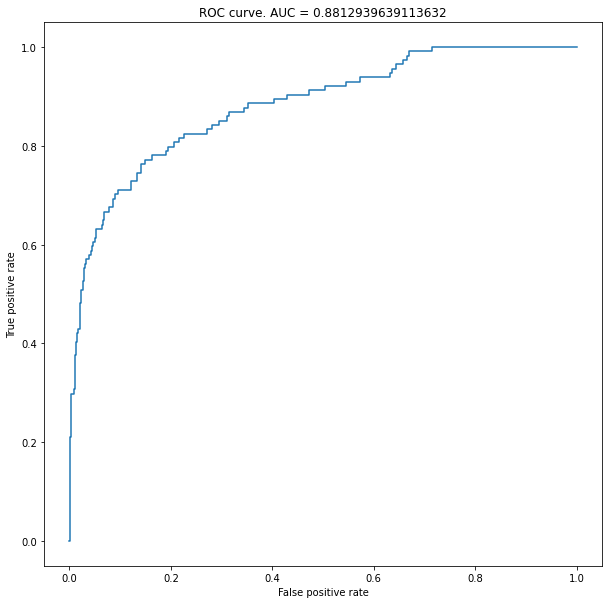

In [ ]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = metrics.roc_curve(y_anomaly, scores_anomaly)
auc = metrics.auc(fpr, tpr)
fig, ax = plt.subplots(1, figsize = (10,10))
ax.plot(fpr,tpr)
ax.set_title(f"ROC curve. AUC = {auc}")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
plt.show()

In [ ]:
auc

0.8812939639113632

In [ ]:
dump(pipeline_anomaly, os.path.join(modelli,'svm_anomaly'))

['/content/drive/MyDrive/ML/testi/modelli/svm_anomaly']